# Identifying anomalous traffic events
In this project, we took a stab at building various models on a large (8GB) dataset that records traffic events across the US from August 2016 to Jan 2021. In addition to preprocessing, I worked on building an isolation forest to identify anomalous traffic events.

The notebook here was used to test code with a subsample of data (~1M records). The code was later run on the entire dataset on an AWS EMR cluster, with buffed up specs. 

The original dataset can be downloaded here:
https://smoosavi.org/datasets/lstw



In [1]:
! pip -q install pyspark==3.0
! pip -q install h2o-pysparkling_3.0
! pip -q install h2o

In [2]:
from google.colab import drive
drive.mount('/content/drive',)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *
from pyspark.ml.feature import *

from h2o.estimators.xgboost import H2OXGBoostEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators import H2OIsolationForestEstimator

from pyspark.sql import SparkSession
from pysparkling import H2OContext
import h2o

import math
import datetime
from datetime import timedelta
import sys
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Launch Spark and H2O Context

In [4]:
ss = SparkSession.builder.getOrCreate()
sc = ss.sparkContext
hc = H2OContext.getOrCreate()

Connecting to H2O server at http://ec3ec9bfab2c:54323 ... successful.


H2O_cluster_uptime:,24 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.1
H2O_cluster_version_age:,"7 days, 23 hours and 14 minutes"
H2O_cluster_name:,sparkling-water-root_local-1617387561613
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"



Sparkling Water Context:
 * Sparkling Water Version: 3.32.1.1-1-3.0
 * H2O name: sparkling-water-root_local-1617387561613
 * cluster size: 1
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (0,172.28.0.2,54321)
  ------------------------

  Open H2O Flow in browser: http://ec3ec9bfab2c:54323 (CMD + click in Mac OSX)

    


# Create data cleaning + feature engineering functions

**Convert to the right data types**
* Spark reads all values as strings when loading a file into a RDD. To convert column into the desired data type, we'll need to create functions returns None if value is an empty string.

**Parse + enhance datetime fields**
* Original datatime column is decomposed to year, month, day, hour, and minute
* Further functions were created to feature engineer date fields such as duration, day of week
* Datetime is in GMT, yet there are various timezones in the dataset. A few functions were created to convert them into local times.

**Missing value imputation**
* We are prioritizing tree models, so missing data is simply replaced with a constant string, or constant highly anomalous integer. 


In [5]:

time_convert = {'US/Central':6, 'US/Mountain':7, 'US/Eastern':5, 'US/Pacific':8}

s_timezone = {'SC':'US/Eastern','AZ':'US/Mountain','LA':'US/Central','MN':'US/Central','NJ':'US/Eastern','OR':'US/Pacific','VA':'US/Eastern','KY':'US/Eastern','WY':'US/Mountain','NH':'US/Eastern','MI':'US/Eastern','NV':'US/Pacific','WI':'US/Central','CA':'US/Pacific','NC':'US/Eastern','MD':'US/Eastern','DE':'US/Eastern','MO':'US/Central','IL':'US/Central','ME':'US/Eastern','WA':'US/Pacific','MS':'US/Central','AL':'US/Central','OH':'US/Eastern','NM':'US/Mountain','NY':'US/Eastern','TX':'US/Central','GA':'US/Eastern','FL':'US/Eastern','CO':'US/Mountain','AR':'US/Central','OK':'US/Central','UT':'US/Mountain'}

def IntegerSafe(value): # In case there are integer type to be converted.
    try:
        return int(value)
    except ValueError:
        return None
def FloatSafe(value): # In case there are float type to be converted.
    try:
        return float(value)
    except ValueError:
        return None

def fill_missing_timezone(tz, state):
    if tz != '':
        return tz
    else: 
        try: 
            return s_timezone[state]
        except:
            return None

def fill_timezone(string):
    if string != '':
        return string
    else: 
        try: 
            return s_timezone[string]
        except:
            return None

def to_epoch(string):
    try:
        timestamp = datetime.datetime.strptime(string, '%Y-%m-%d %H:%M:%S').timestamp()
        return timestamp
    except:
        return None

def datetime_decompose(row, string):
    try:
        d = datetime.datetime.strptime(string, '%Y-%m-%d %H:%M:%S')
        d = d - timedelta(hours=time_convert[row[7]])
        return [d.year, d.month, d.day, d.hour, d.minute, d.second]
    except:
        return [None] * 6

def the_day_of_week(string):
    try:
        w = datetime.datetime.strptime(string, '%Y-%m-%d %H:%M:%S').weekday()
        return w
    except:
        return None 
        
def safe_date_subtraction(x):
    try:
        return to_epoch(x[6]) -  to_epoch(x[5])
    except:
        return None

def imputer(df, impute_val=0, impute_str='Missing'):
    num_imputed = df.na.fill(impute_val)
    string_cols = [x.name for x in df.schema.fields if x.dataType == StringType()]
    all_imputed = num_imputed.replace([''], [impute_str], string_cols)
    return all_imputed


# Load and clean data
Data is first loaded as a RDD, then mapped onto data cleansing functions. Lastly, it's converted into a Spark dataframe for modeling.

In [6]:

# load raw file 
traffic = sc.textFile("drive/MyDrive/sampler/traffic-sample-1m.csv")

# remove header
header = traffic.first()
traffic = traffic.filter(lambda x: x != header)\
                 .map(lambda x : x.split(','))                 

# fillin missing timezone
traffic = traffic.map(lambda x: x[:7] + 
                      [fill_missing_timezone(x[7], x[17])]+ 
                      x[8:])

# reset datatype
traffic = traffic.map(lambda x : tuple([x[1], x[2], IntegerSafe(x[3]), x[4],
                              safe_date_subtraction(x),
                              the_day_of_week(x[5]), 
                              to_epoch(x[5])] +  
                              datetime_decompose(x, x[5]) +
                              [to_epoch(x[6])] + 
                              datetime_decompose(x, x[6]) +
                              [x[7], FloatSafe(x[8]), FloatSafe(x[9]), FloatSafe(x[10]),
                              x[11], IntegerSafe(x[12]), x[13], x[14], x[15], 
                              x[16], x[17], IntegerSafe(x[18])]) )

schema = StructType([ StructField("Type", StringType(), True),
                      StructField("Severity", StringType(), True),
                      StructField("TMC", IntegerType(), True),
                      StructField("Description", StringType(), True),
                      StructField("Duration", DoubleType(), True),
                      StructField("DayOfWeek", IntegerType(), True),
                      StructField("StartTime", DoubleType(), True),
                      StructField("StartTimeYear", IntegerType(), True),
                      StructField("StartTimeMonth", IntegerType(), True),
                      StructField("StartTimeDay", IntegerType(), True),
                      StructField("StartTimeHour", IntegerType(), True),
                      StructField("StartTimeMinute", IntegerType(), True),
                      StructField("StartTimeSecond", IntegerType(), True),
                      StructField("EndTime", DoubleType(), True),
                      StructField("EndTimeYear", IntegerType(), True),
                      StructField("EndTimeMonth", IntegerType(), True),
                      StructField("EndTimeDay", IntegerType(), True),
                      StructField("EndTimeHour", IntegerType(), True),
                      StructField("EndTimeMinute", IntegerType(), True),
                      StructField("EndTimeSecond", IntegerType(), True),
                      StructField("TimeZone", StringType(), True),
                      StructField("LocationLat", DoubleType(), True),
                      StructField("LocationLng", DoubleType(), True),
                      StructField("Distance", DoubleType(), True),
                      StructField("AirportCode", StringType(), True),
                      StructField("Number", IntegerType(), True),
                      StructField("Street", StringType(), True),
                      StructField("Side", StringType(), True),
                      StructField("City", StringType(), True),
                      StructField("County", StringType(), True),
                      StructField("State", StringType(), True),
                      StructField("Zipcode", IntegerType(), True),
                    ])

traffic_df = ss.createDataFrame(traffic, schema)
traffic_df = imputer(traffic_df, impute_val=-99999)

# Building an Isolation Forest
Goal: I'll be comparing 'Type' distribution of the entire dataset against anomalies.


In [7]:
traffic_df.show(2)

+----------+--------+---+--------------------+--------+---------+------------+-------------+--------------+------------+-------------+---------------+---------------+-------------+-----------+------------+----------+-----------+-------------+-------------+----------+-----------+-----------+-------------+-----------+------+-------+----+----------+-----------+-----+-------+
|      Type|Severity|TMC|         Description|Duration|DayOfWeek|   StartTime|StartTimeYear|StartTimeMonth|StartTimeDay|StartTimeHour|StartTimeMinute|StartTimeSecond|      EndTime|EndTimeYear|EndTimeMonth|EndTimeDay|EndTimeHour|EndTimeMinute|EndTimeSecond|  TimeZone|LocationLat|LocationLng|     Distance|AirportCode|Number| Street|Side|      City|     County|State|Zipcode|
+----------+--------+---+--------------------+--------+---------+------------+-------------+--------------+------------+-------------+---------------+---------------+-------------+-----------+------------+----------+-----------+-------------+--------

In [11]:
traffic_df.groupBy('Type').count().show()

+--------------+------+
|          Type| count|
+--------------+------+
|         Event|  1489|
|Broken-Vehicle| 20634|
|  Construction| 23386|
|  Lane-Blocked| 16015|
|    Congestion|800113|
| Flow-Incident| 53783|
|      Accident| 84580|
+--------------+------+



In [ ]:
a1 = traffic_df.where((traffic_df.Type == 'Accident' ) & (traffic_df.Severity != 'Missing')).count()
a2 = traffic_df.where((traffic_df.Type == 'Accident' )).count()
print(f'Accident with severity value: {a1}')
print(f'Accident w/o severity value: {a2}')

a1 = traffic_df.where((traffic_df.Type == 'Accident' ) & (traffic_df.TMC != -99999)).count()
a2 = traffic_df.where((traffic_df.Type == 'Accident' )).count()
print(f'Accident with TMC value: {a1}')
print(f'Accident w/o TMC value: {a2}')

Accident with severity value: 0
Accident w/o severity value: 84580
Accident with TMC value: 84580
Accident w/o TMC value: 84580


* Since severity values are only associated with non-accident types, I'll be removing it from the training.
* According to the dataset description, TMC is also strongly related to Type, as it simply a finer classification of type. Hence I'll also be removing that from the dataset.



In [12]:
# no standard scaler or ohe needed for h2o forest models
traffic_h2o = hc.asH2OFrame(traffic_df)

# get predictors
# drop severity, since accident rows don't have severity value
# drop TMC since it directly relates to accident description
# drop type, which contains [Event, Broken-Vehicle, Construction, Lane-Blocked, Congestion, Flow-Incident, Accident]

predictors = traffic_h2o.names
predictors.remove('Severity')
predictors.remove('Type')
predictors.remove('TMC')

isolation_model = H2OIsolationForestEstimator()
isolation_model.train(training_frame=traffic_h2o, x=predictors)

predictions = isolation_model.predict(traffic_h2o)


Dropping bad and constant columns: [Description]


isolationforest Model Build progress: |███████████████████████████████████| 100%
isolationforest prediction progress: |████████████████████████████████████| 100%


In [13]:
# export predictions for plotting
export_path = 'iforest-pred-outcome'
predictions_sp = hc.asSparkFrame(predictions)
predictions_sp.coalesce(1).write.csv(path=export_path, mode="append", header="true")

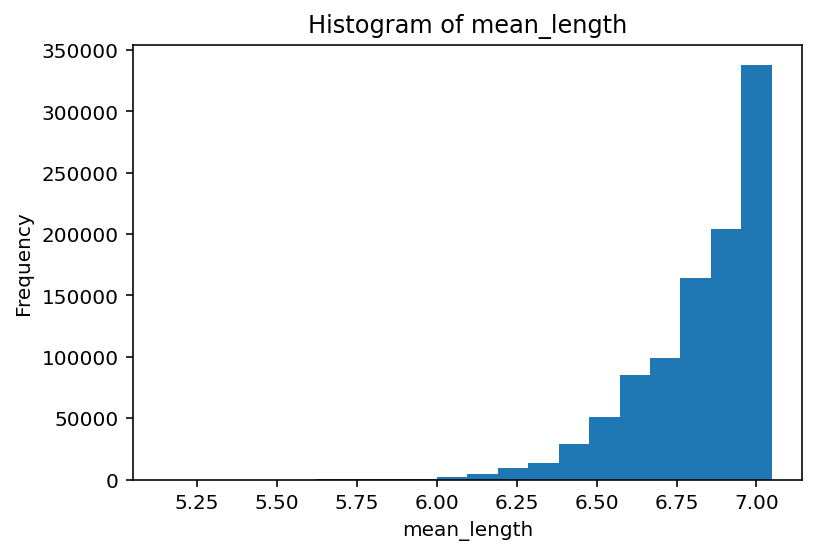

In [21]:
# evaluate iforest model
# plot average depth
predictions['mean_length'].hist()


From the histrogram, I've visually determined that the anoamly cutoff threshold is <6. This means any record requires less than 6 splits to isolate is considered anoamlous.

In [22]:
# get Type distribution for entire dataset
type_cnt = traffic_h2o['Type'].table()
total_rec = len(traffic_h2o)
type_perc = type_cnt['Count'].apply(lambda x: np.round(x/total_rec * 100, 2))
type_cnt_perc = type_cnt.cbind(type_perc)\
                        .rename(columns={'Count0': 'Count Perc'})\
                        .sort('Count', ascending=0)

# get Type distribution for just anomaly dataset
threshold = 6 # avg depths required to isolate record
anomaly = traffic_h2o[predictions['mean_length'] < threshold]
anomaly_type_cnt = anomaly['Type'].table()
anomaly_total_rec = len(anomaly)
anomaly_type_perc = anomaly_type_cnt['Count'].apply(lambda x: np.round(x/anomaly_total_rec * 100, 2))

anomaly_type_cnt_perc = anomaly_type_cnt.cbind(anomaly_type_perc)\
                        .rename(columns={'Count0': 'Count Perc'})\
                        .sort('Count', ascending=0)

print(type_cnt_perc)
print(anomaly_type_cnt_perc)





# tally up overall anomaly distribution
traffic_h2o_copy = traffic_h2o[:, :]
traffic_h2o_copy["Anomaly"] = (predictions["mean_length"] < threshold).ifelse("Yes", "No")
anomaly_cnt = traffic_h2o_copy["Anomaly"].table()
anomaly_perc = anomaly_cnt['Count'].apply(lambda x: x/total_rec * 100)

anomaly_cnt.cbind(anomaly_perc)\
                        .rename(columns={'Count0': 'Count Perc'})\
                        .sort('Count', ascending=0)


Type,Count,Count Perc
Congestion,800113,80.01
Accident,84580,8.46
Flow-Incident,53783,5.38
Construction,23386,2.34
Broken-Vehicle,20634,2.06
Lane-Blocked,16015,1.6
Event,1489,0.15


Type,Count,Count Perc
Congestion,2209,43.54
Construction,1588,31.3
Accident,651,12.83
Flow-Incident,282,5.56
Lane-Blocked,137,2.7
Event,106,2.09
Broken-Vehicle,101,1.99


Anomaly,Count,Count Perc
No,994926,99.4926
Yes,5074,0.5074


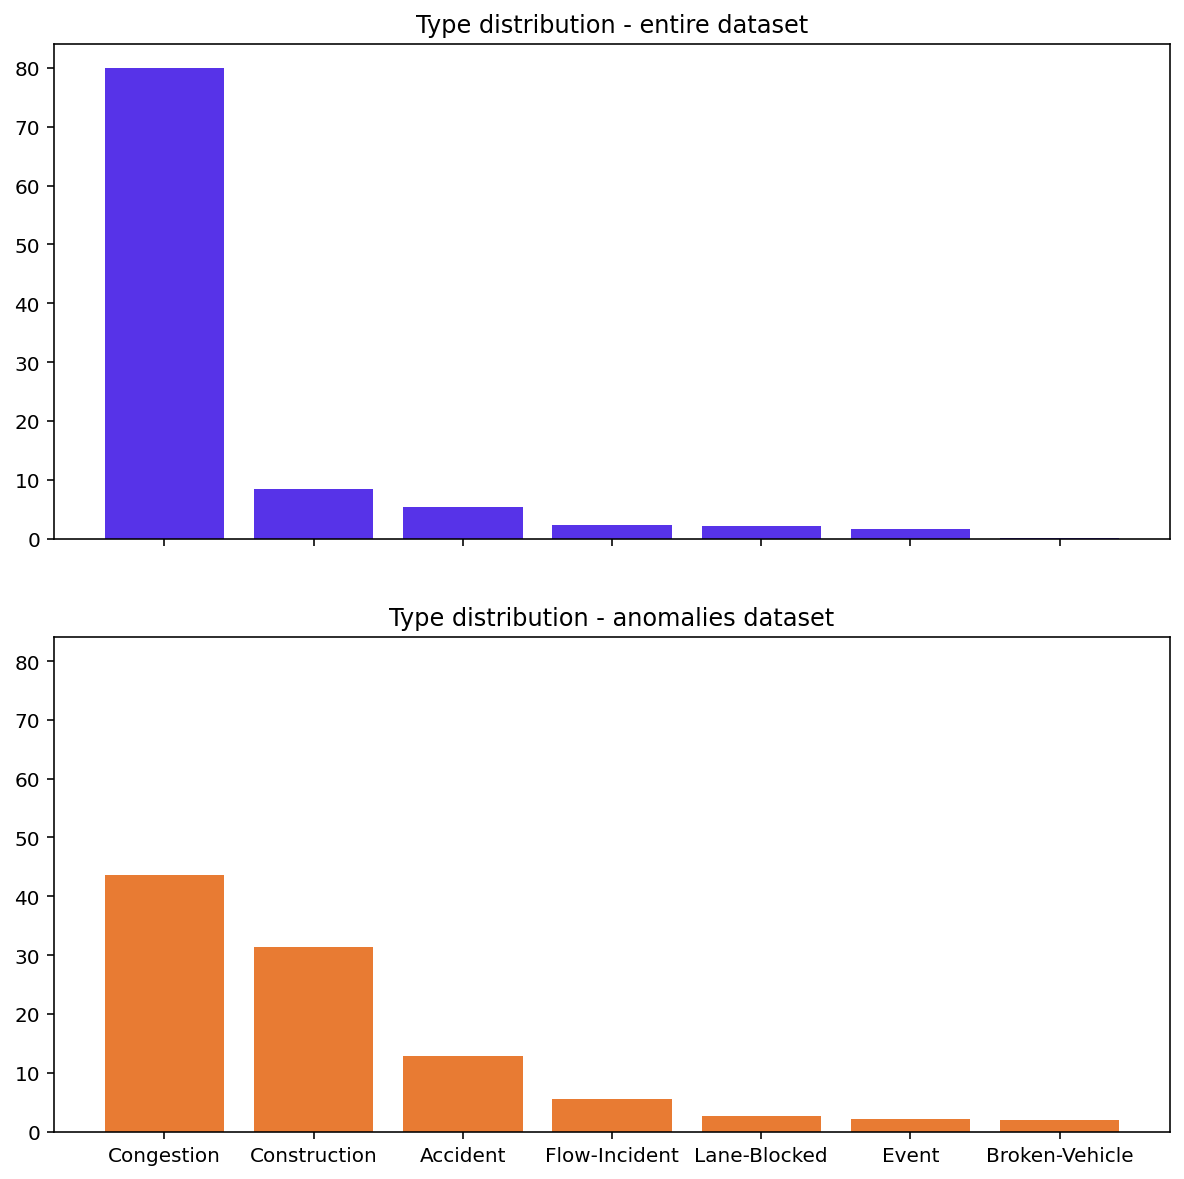

In [58]:
all_type_dist = type_cnt_perc.as_data_frame()
ana_type_dist = anomaly_type_cnt_perc.as_data_frame()

fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(10, 10), sharey=True, sharex=True)

ax[0].bar(all_type_dist.Type, all_type_dist['Count Perc'], color='#5733e8')
ax[1].bar(ana_type_dist.Type, ana_type_dist['Count Perc'], color='#e87b33')
ax[0].set_title('Type distribution - entire dataset')
ax[1].set_title('Type distribution - anomalies dataset')
plt.show()

## Key takeaway
At threshold = depth 6, aboutu 0.5% of the data was identified as anomalous. 
Anomaly traffic type were indeed distributed differently from the entire dataset, with construction events coming in at a close second in frequency.


# What makes them anomalies? 
In the section, I fit a decision tree on the entire dataset to find splits that result in anoamly labels. The target variable is essentially the outcome from iforest with encoded in boolean where 0='not anomalous' and 1='anomalous'.


In [24]:
global_surrogate_data = traffic_h2o.cbind(predictions['mean_length'])
global_surrogate_data["Anomaly"] = (predictions["mean_length"] < threshold).ifelse("Yes", "No")
global_surrogate_data["Anomaly"].table()


h2o.export_file(global_surrogate_data, 'iforest-transformed-traffic.')

Export File progress: |███████████████████████████████████████████████████| 100%


In [25]:
from h2o.estimators import H2ORandomForestEstimator

global_surrogate_dt = H2ORandomForestEstimator(ntrees=1, max_depth=3,
                                               sample_rate=1, mtries=len(predictors)-2)
global_surrogate_dt.train(training_frame = global_surrogate_data, x=predictors, y="Anomaly")

Dropping bad and constant columns: [Description]
Sample rate is 100% and no validation dataset and no cross-validation. There are no out-of-bag data to compute error estimates on the training data!


drf Model Build progress: |███████████████████████████████████████████████| 100%


In [26]:
global_surrogate_dt.download_mojo(get_genmodel_jar=True)

'/content/DRF_model_python_1617387563242_2.zip'

In [66]:
import os
import subprocess
from IPython.display import Image
def generateTreeImage(decision_tree, image_file_path):
    # Download MOJO
    mojo_path = decision_tree.download_mojo(get_genmodel_jar=True)
    directory = os.path.dirname(mojo_path)
    h2o_jar_path = os.path.join(directory, "h2o-genmodel.jar")
    # Create Graphviz file
    gv_file_path = os.path.join(directory, "decision_tree.gv")
    gv_call = " ".join(["java", "-cp", h2o_jar_path, "hex.genmodel.tools.PrintMojo", "--tree 0 -", mojo_path , "-o", gv_file_path])
    result = subprocess.call(gv_call, shell=True)
    result = subprocess.call(["ls", gv_file_path], shell = False)
    result = subprocess.call(["dot", "-Tpng", gv_file_path, "-o", image_file_path], shell=False)
    result = subprocess.call(["ls",image_file_path], shell = False)
    
    return Image(image_file_path)

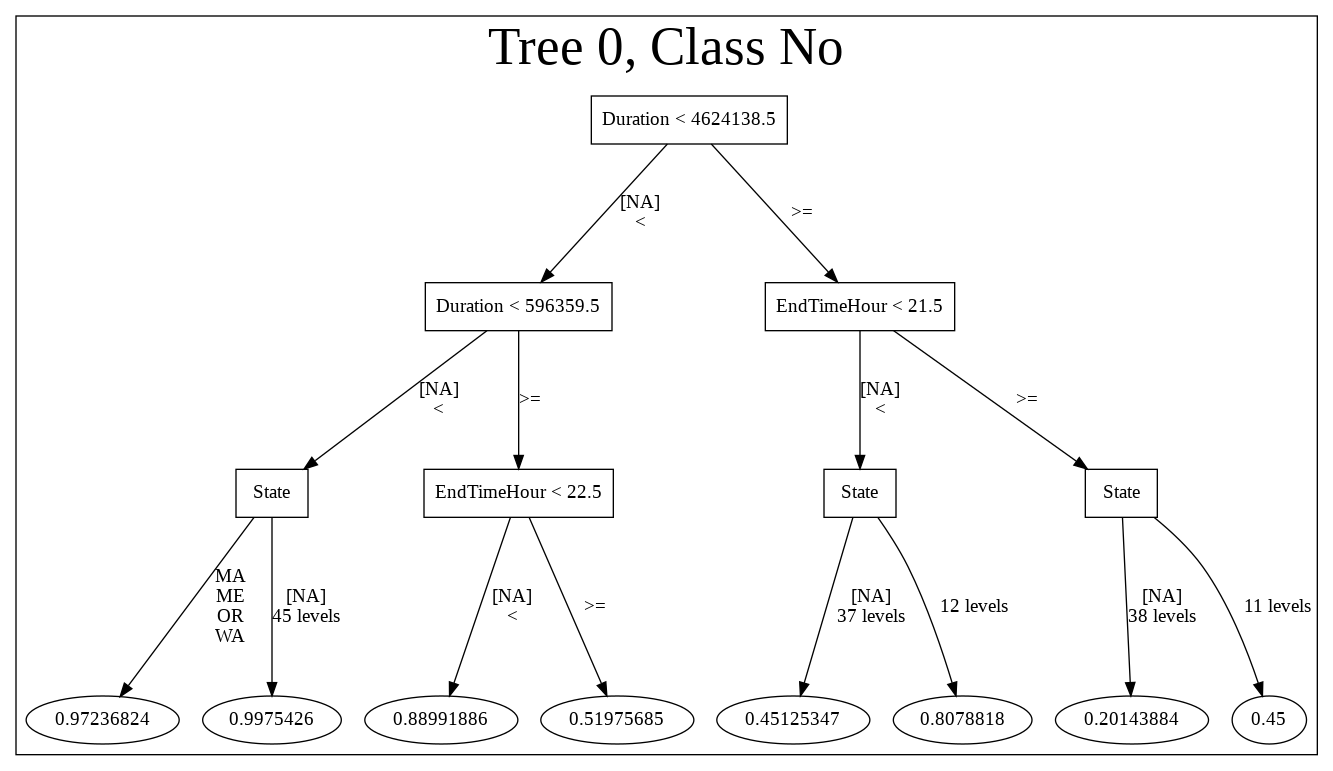

In [67]:
generateTreeImage(global_surrogate_dt, "./global_surrogate_decision_tree.png")


## Key takeway
The leaf node values represent probability of not being an anomaly. Therefore, leaves with low value of relevant to how we interpret anomalies. 

It appears that events with longer durations and later ending hours had the highest likelihood of being anomalous. This makes sense in the context of constructions, which typically spans over days, as opposed to congestions that spam over a few hours. 